In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import shutil

def copy_netcdf(source_file, dest_file):
    # Open the source file
    with nc.Dataset(source_file, 'r') as src:
        # Open the destination file
        with nc.Dataset(dest_file, 'w') as dst:
            # Copy dimensions
            for name, dimension in src.dimensions.items():
                dst.createDimension(name, (len(dimension) if not dimension.isunlimited() else None))
            
            # Copy variables
            for name, variable in src.variables.items():
                x = dst.createVariable(name, variable.datatype, variable.dimensions)
                dst[name][:] = src[name][:]
                
                # Copy variable attributes
                for attr_name in variable.ncattrs():
                    setattr(x, attr_name, getattr(variable, attr_name))
            
            # Copy global attributes
            for attr_name in src.ncattrs():
                setattr(dst, attr_name, getattr(src, attr_name))

# Replace with your file paths
source_file = '/Users/changyichieh/Documents/Hot Jupiter/erainterim_moda_L60_N24_200001010000000.nc'
dest_file = '/Users/changyichieh/Documents/Hot Jupiter/copy_netcdf.nc'

copy_netcdf(source_file, dest_file)


In [2]:
df = nc.Dataset(dest_file, 'a')
df
df_origin = nc.Dataset(source_file, 'r')
df_origin

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    CDI: Climate Data Interface version 1.5.4 (http://code.zmaw.de/projects/cdi)
    Conventions: CF-1.4
    history: Thu Jan 21 13:26:27 2016: cdo -f nc copy erainterim_moda_L60_N24_200001010000000 erainterim_moda_L60_N24_200001010000000.nc
    institution: European Centre for Medium-Range Weather Forecasts
    CDO: Climate Data Operators version 1.5.4 (http://code.zmaw.de/projects/cdo)
    dimensions(sizes): lon(96), lat(48), lev(60), nhym(60), nhyi(61), lev_2(1), time(1)
    variables(dimensions): float64 lon(lon), float64 lat(lat), float64 lev(lev), float64 hyai(nhyi), float64 hybi(nhyi), float64 hyam(nhym), float64 hybm(nhym), float64 lev_2(lev_2), float64 time(time), float32 var130(time, lev, lat, lon), float32 var133(time, lev, lat, lon), float32 var152(time, lev_2, lat, lon), float32 var129(time, lev_2, lat, lon), float32 var131(time, lev, lat, lon), float32 var132(time, lev, lat, l

## Plot the temperature

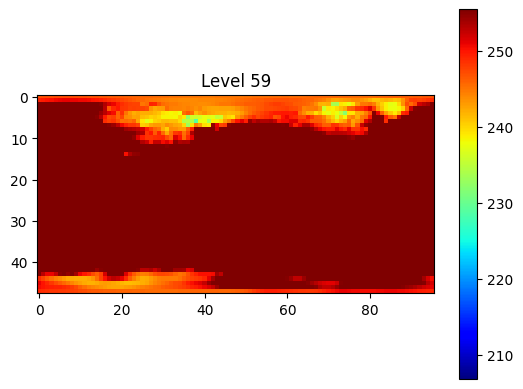

In [3]:
Temperature = df_origin.variables['var130'][:]
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()
cax = ax.imshow(Temperature[0, 0, :, :], cmap='jet')
fig.colorbar(cax)

# Animation update function
def update(frame):
    cax.set_data(Temperature[0, frame, :, :])
    ax.set_title(f"Level {frame}")
    return cax,

# Create animation
ani = FuncAnimation(fig, update, frames=Temperature.shape[1], blit=True)



# To save the animation
ani.save('temperature_animation.mp4')


## Modify the .nc file

#### Set the temperature, u,v to 0.0 

In [4]:
df.variables['var130'][:] = 0
df.variables['var131'][:] = 0
df.variables['var132'][:] = 0

In [5]:
df.close()

In [6]:
df = nc.Dataset(dest_file, 'a')
df.variables['var131'][:]

masked_array(
  data=[[[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],

         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],

         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],

         ...,

         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
   

In [7]:
df_Hd = pd.read_csv('/Users/changyichieh/Documents/Hot Jupiter/Hot_Jupiter_Github/hot_jupiter/Parmentier 2/PTprofile(20bar)(Hd209458b)(0103).csv')

new_df = pd.DataFrame()

new_df['N'] = df_Hd['N']
new_df['P'] = df_Hd['P(Pa)']


new_df['ak'] = df_Hd['P(Pa)']
new_df['bk'] = 0
new_df['ph'] = df_Hd['P(Pa)']
# pf is the midpoint pressure of each layer
new_df['pf'] = (new_df['P'] + new_df['P'].shift(1)) / 2
new_df.loc[0, 'pf'] = new_df.loc[0, 'P']/2  # or any other method you find suitable


if 'hyam' in df.variables:
    df.variables['hyam'][:] = new_df['pf']

if 'hybm' in df.variables:
    df.variables['hybm'][:] = 0

# insert a N=0 row
new_df.loc[-1] = 0  # adding a row
new_df.index = new_df.index + 1  # shifting index
new_df = new_df.sort_index()  # sorting by index

del new_df['P']


if 'hybi' in df.variables:
    df.variables['hybi'][:] = new_df['bk']

if 'hyai' in df.variables:
    df.variables['hyai'][:] = new_df['ak']






In [8]:
# check the dimensions of all variables
for i in df.variables.keys():
    print(i, df.variables[i].shape)

print(df['hyai'][:])
print(df_origin['hyai'][:])

# Close the file
# df.close()

lon (96,)
lat (48,)
lev (60,)
hyai (61,)
hybi (61,)
hyam (60,)
hybm (60,)
lev_2 (1,)
time (1,)
var130 (1, 60, 48, 96)
var133 (1, 60, 48, 96)
var152 (1, 1, 48, 96)
var129 (1, 1, 48, 96)
var131 (1, 60, 48, 96)
var132 (1, 60, 48, 96)
[0.00e+00 1.00e+01 1.23e+01 1.51e+01 1.86e+01 2.29e+01 2.81e+01 3.46e+01
 4.26e+01 5.23e+01 6.44e+01 7.92e+01 9.73e+01 1.20e+02 1.47e+02 1.81e+02
 2.23e+02 2.74e+02 3.37e+02 4.14e+02 5.09e+02 6.27e+02 7.71e+02 9.48e+02
 1.17e+03 1.43e+03 1.76e+03 2.17e+03 2.67e+03 3.28e+03 4.03e+03 4.96e+03
 6.10e+03 7.50e+03 9.23e+03 1.13e+04 1.40e+04 1.72e+04 2.11e+04 2.60e+04
 3.19e+04 3.93e+04 4.83e+04 5.94e+04 7.30e+04 8.98e+04 1.10e+05 1.36e+05
 1.67e+05 2.05e+05 2.53e+05 3.11e+05 3.82e+05 4.70e+05 5.78e+05 7.11e+05
 8.74e+05 1.08e+06 1.32e+06 1.63e+06 2.00e+06]
[0.00000000e+00 2.00000000e+01 3.84253387e+01 6.36477966e+01
 9.56369629e+01 1.34483307e+02 1.80584351e+02 2.34779053e+02
 2.98495850e+02 3.73971924e+02 4.64618164e+02 5.75651123e+02
 7.13218018e+02 8.83660400e+

In [9]:
# df['hyai'] -> model level a
# df['hybi'] -> model level b
# df['hyam'] # -> model level mid a
# df['hybm'] # -> model level mid b

# lev_2 -> bottom level ???


# ----------------------------

# var130 : temperature 
# var133 : specific humidity
# var152 : Logarithm of surface pressure

# var129 : Geopotential
# var131 : u-component of wind
# var132 : v-component of wind





df['lev_2']

<class 'netCDF4._netCDF4.Variable'>
float64 lev_2(lev_2)
    standard_name: hybrid_sigma_pressure
    long_name: hybrid level at layer midpoints
    units: level
    positive: down
    formula: hyam hybm (mlev=hyam+hybm*aps)
    formula_terms: ap: hyam b: hybm ps: aps
unlimited dimensions: 
current shape = (1,)
filling on, default _FillValue of 9.969209968386869e+36 used